# Rastermap prototype
* setup 1/27/24
* works with a single session
* the shading for moving/not moving intervals sometimes doesn't work

In [1]:
import sys
import json
from os.path import join, dirname
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from rastermap import Rastermap

sys.path.append("/home/gergely/code/sleep/src")

from classes.suite2p_class import Suite2p as s2p
import classes.imaging_data_class as idc
import classes.behavior_class as bc

### Global variables

In [2]:
mouse_id = "5HT2afl05b_2"

In [3]:
imaging_data = idc.ImagingData(mouse_id=mouse_id)
s2p_folders = [
    (index, folder) for index, folder in enumerate(imaging_data.find_s2p_folders())
]
s2p_folders

Looking for Suite2p folders in /data2/gergely/invivo_DATA/sleep/5HT2afl05b_2


[(0,
  '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima/suite2p'),
 (1,
  '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima/s2p_ff/suite2p'),
 (2,
  '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima/suite2p'),
 (3,
  '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima/s2p_ff/suite2p'),
 (4,
  '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima/suite2p'),
 (5,
  '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima/s2p_ff/suite2p'),
 (6,
  '/data2/gergel

In [15]:
folder_to_load = 2
s2p_folder = s2p_folders[folder_to_load][1]

In [16]:
s2p_data = s2p(s2p_folder)
spikes = s2p_data.get_spikes()
# z scoring
n_neurons, n_time = spikes.shape
spks = zscore(spikes, axis=1)

/home/gergely/code/sleep/src/classes/suite2p_class.py:76: UserWarning: Combined directory not found, falling back to plane0.
  warnings.warn(


In [18]:
behavior = bc.behaviorData(mouse_id=mouse_id)
behavior_folders = [
    (index, folder) for index, folder in enumerate(behavior.find_behavior_folders())
]
behavior_folders

Searching for behavior folders in /data2/gergely/invivo_DATA/sleep/5HT2afl05b_2
Searching for behavior folders in /data2/gergely/invivo_DATA/sleep/5HT2afl05b_2


[(0,
  '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima/behavior'),
 (1,
  '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima/behavior'),
 (2,
  '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-003/TSeries-07062021-0844_GC-003_Cycle00001_Element00001.sima/behavior'),
 (3,
  '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima/behavior'),
 (4,
  '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_1/TSeries-07012021-0854-001/TSeries-07012021-0854-001_Cycle00001_Element00001.sima/behavior'),
 (5,
  '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_7_Zstacks/TSeries-07072021-0833_MC_pento-002/TSeries-07072021-0833_MC_pento-002_Cycle00001_Element00001.sima/behavior'),
 (6,
  '/data2/gergely/invivo_

In [19]:
beh_folder_to_load = 1
behavior_file = "5ht2afl05b_2_20210706112012_761_sleep.json"

In [20]:
processed_behavior = behavior_folders[beh_folder_to_load][1]

if not dirname(processed_behavior) == dirname(s2p_folder):
    raise ValueError("Behavior and imaging data folders do not match")

try:
    with open(join(processed_behavior, behavior_file), "r") as f:
        beh = json.load(f)
except FileNotFoundError:
    print("File not found")

In [21]:
with open(join(processed_behavior, "filtered_velocity.json"), "r") as f:
    speed = np.array(json.load(f))

position = np.array(beh[0]["data"]["treadmillPosition"])

with open(join(processed_behavior, "mobility_immobility.json"), "r") as f:
    mob_immob = np.array(json.load(f))

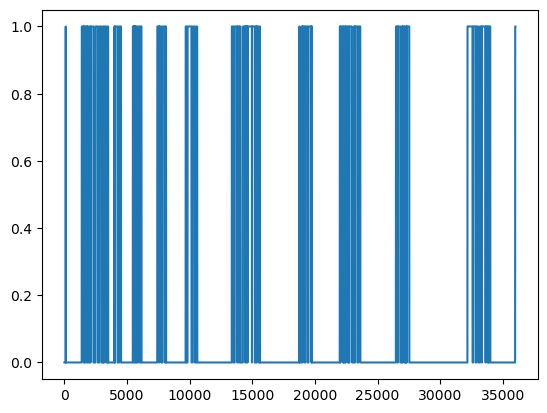

In [32]:
plt.plot(mob_immob)

### Averaging spikes based on behavior:

In [23]:
delta_t = 0.096691  # sampling rate of the imaging data
moving_spks = spks[:, mob_immob == 1].mean()
notmoving_spks = spks[:, ~mob_immob == 1].mean()

# calculating spike rates:
total_duration_moving = np.sum(mob_immob == 1) * delta_t
total_duration_notmoving = np.sum(~mob_immob == 1) * delta_t

moving_rate = moving_spks / total_duration_moving if total_duration_moving > 0 else 0
notmoving_rate = (
    notmoving_spks / total_duration_notmoving if total_duration_notmoving > 0 else 0
)

data = {
    "Condition": ["Moving", "Not Moving"],
    "Mean Value": [moving_spks, notmoving_spks],
    "Mean Rate": [moving_rate, notmoving_rate],
}

df = pd.DataFrame(data)
df["Condition"] = df["Condition"].astype("category")
condition_mapping = {"Moving": 1, "Not Moving": 2}
df["Condition_numeric"] = df["Condition"].map(condition_mapping)
df.to_json(
    join(dirname(processed_behavior), "mobility_immobility_mean_spike_rate.json")
)

In [24]:
moving_spks

0.12422953

/home/gergely/anaconda3/envs/sleep/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


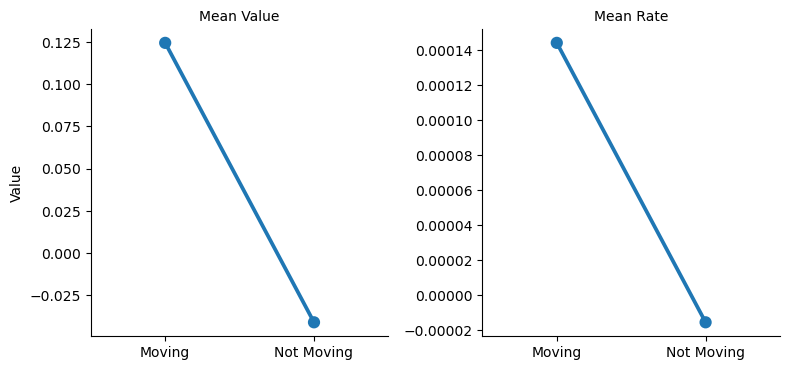

In [25]:
# Convert the data to a long-format DataFrame
df_long = pd.DataFrame(data)
df_long = pd.melt(df_long, id_vars="Condition", var_name="Metric", value_name="Value")

# Use Seaborn's catplot to create point plots
g = sns.catplot(
    x="Condition",
    y="Value",
    col="Metric",
    data=df_long,
    kind="point",
    height=4,
    aspect=1,
    sharey=False,
)

# Adjust the plot aesthetics
g.set_titles("{col_name}")
g.set_axis_labels("", "Value")
plt.savefig(
    join(dirname(processed_behavior), "mobility_immobility_mean_and_spike_rate.png")
)
plt.show()

In [26]:
# the number of PCs to calculate is half the number of neurons
PCs = int(np.ceil(spks.shape[0] / 2))
PCs

25

In [27]:
type(spks)

numpy.ndarray

In [28]:
model = Rastermap(
    n_clusters=None,  # None turns off clustering and sorts single neurons
    n_PCs=PCs,  # use fewer PCs than neurons
    locality=0.5,  # some locality in sorting (this is a value from 0-1)
    time_lag_window=15,  # use future timepoints to compute correlation
    grid_upsample=0,  # 0 turns off upsampling since we're using single neurons
    time_bin=5,
).fit(spks)
y = model.embedding  # neurons x 1
isort = model.isort

normalizing data across axis=1
binning in time with time_bin = 5
projecting out mean along axis=0
data normalized, 0.02sec
sorting activity: 49 valid samples by 36000 timepoints
n_PCs = 25 computed, 0.03sec


/home/gergely/anaconda3/envs/sleep/lib/python3.8/site-packages/rastermap/rastermap.py:343: UserWarning: data has <= 50 samples, 

                                going to skip clustering and sort samples
  warnings.warn("""data has <= 50 samples, \n


clusters sorted, time 0.57sec
rastermap complete, time 0.57sec


compute tuning curve for each neuron

In [29]:
len(position)

75000

In [30]:
n_pos = 100
bins = np.arange(0, 1 + 1.0 / n_pos, 1.0 / n_pos)
ibin = np.digitize(position, bins) - 1
n_bins = ibin.max()
inan = np.isnan(position)
ibin[inan] = -1
tcurves = np.zeros((spks.shape[0], n_bins))
for b in range(n_bins):
    tcurves[:, b] = spks[:, ibin == b].mean(axis=1)
tcurves -= tcurves.mean(axis=1, keepdims=True)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 36000 but corresponding boolean dimension is 75000

In [ ]:
# make figure with grid for easy plotting
from turtle import down

fig = plt.figure(figsize=(12, 8), dpi=200)
grid = plt.GridSpec(10, 24, figure=fig, wspace=0.1, hspace=0.4)
# time = np.linspace(0, 3600, 36000)

# plot location
ax = plt.subplot(grid[0, :-5])
ax.plot(position, lw=1)  # , color=kp_colors[0])
ax.set_xlim([0, len(position)])
ax.axis("off")
ax.set_title("2D location")

# plot running speed
ax = plt.subplot(grid[1, :-5])
ax.plot(speed, color=0.5 * np.ones(3), lw=1)
ax.set_xlim([0, len(speed)])
ax.axis("off")
ax.set_title("running speed")

# Plot spike mean for each condition (moving vs. not moving)
ax = plt.subplot(grid[0:2, -3:])
colors = ["#4c72b0", "#dd8452"]  # Specify colors for each condition
for cond, color in zip(condition_mapping.keys(), colors):
    cond_data = df[df["Condition"] == cond]
    ax.scatter(cond_data["Condition_numeric"], cond_data["Mean Value"], color=color)

# Adjusting plot aesthetics
ax.set_xticks(list(condition_mapping.values()))
ax.set_xticklabels(list(condition_mapping.keys()), fontsize=6)
ax.tick_params(axis="y", labelsize=6)
ax.set_xlim(0.5, 2.5)
ax.set_ylabel("Z-Scored Mean", fontsize=6)
ax.set_title("Spike Mean", fontsize=6)
sns.despine()

# plot sorted neural activity
ax = plt.subplot(grid[2:, :-5])
time_extent = [0, 3600, 0, spks.shape[0]]  # [xmin, xmax, ymin, ymax]
ax.imshow(
    spks[isort], cmap="gray_r", vmin=0, vmax=1.2, aspect="auto", extent=time_extent
)
ax.set_xlabel("time")
ax.set_ylabel("superneurons")

# Shaded mobility periods
down_mobility = np.array(
    [any(mob_immob[i : i + 10]) for i in range(0, len(mob_immob), 10)]
)
mobility = down_mobility.astype(int)
# Assuming x-axis aligns with the length of immobility array
x = np.arange(len(mobility))

# Find where immobility periods start and end
immobility_starts = np.where(np.diff(mobility) == 1)[0] + 1
immobility_ends = np.where(np.diff(mobility) == -1)[0]

# Plot immobility periods
for start, end in zip(immobility_starts, immobility_ends):
    ax.fill_between(x[start:end], 0, spks.shape[0], color="#FA8072", alpha=0.3)

# plot single-neuron tuning curves
ax = plt.subplot(grid[2:, -5:])
x = np.arange(0, n_bins)
dy = 2
# xpad = n_pos / 10
nn = spks.shape[0]
for t in range(len(tcurves)):
    ax.plot(x, tcurves[isort[t], :n_pos] * dy - dy / 2 + nn - t, color="k", lw=0.5)

ax.text(n_pos / 2, -14, "position", ha="center")
ax.text(0, -3, "0")
ax.text(n_pos, -3, "2", ha="right")
ax.set_ylim([0, nn])
ax.axis("off")
plt.show()
plt.tight_layout()

# fig.savefig(join(processed_behavior, "rastermap.png"), dpi=300)

In [ ]:
y = model.embedding[:, 0]
plt.scatter(xpos, ypos, cmap="gist_rainbow", c=y, s=1)